# Band ratio plots on HiRISE dark subtraction images

## Define functions

In [9]:
import rasterio
from rasterio.mask import mask
import fiona
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import geopandas as gpd
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Define functions and dictionaries

plt.style.use('dark_background')

# Point color dictionary
mineral_colors = {'plagioclase': 'gold', 'lcp': 'cyan', 
                'olivine': 'red', 'light_toned_massive': 'white', 'dark_toned_massive': 'blueviolet',
                'olivine+plagioclase': 'orangered', 'olivine+hcp': 'purple',
                'light_toned_rubble': 'yellow', 'hcp': 'magenta', 'dark_toned_rubble': 'darkblue',
                'light_toned_bench': 'yellowgreen', 'light_banded': 'limegreen',
                'dark_toned_plateau': 'darkgray', 'red_toned': 'brown', 'pink_toned': 'pink',
                'banded': 'darkslategray', 'blue_outcrop': 'blue', 'blue_terrain': 'skyblue',
                'light_toned_muted': 'goldenrod', 'ice': 'lightblue', 'bland': 'darkkhaki',
                'sand': 'khaki', 'dark_sand': 'darkviolet', 'purple_sand': 'purple', 'orange_sand': 'orange', 'blue_sand': 'blue',
                'rubble': 'blue','light_toned_ridge': 'lightgray', 'dark_sub': 'black', 
                'dark_lava': 'violet', 'dark_toned_ridge': 'darkgray'}

# Define functions
def calculate_parameters(spectrum, numerator='IR', denominator='BG'):
    # Wavelengths for the respective bands (in nm)
    wIR = 900  # Near-Infrared
    wRed = 700  # Red
    wBG = 500  # Blue/Green

    # Extract each band (assuming order is RGB: Red, Green, Blue)
    band1, band2, band3 = spectrum
    
    band_dict = {'IR': band1, 'Red': band2, 'BG': band3}

    # Calculate Band 1 / Band 3 ratio (avoid division by zero and infinity)
    with np.errstate(divide='ignore', invalid='ignore'):
        band_ratio = np.true_divide(band_dict[numerator], band_dict[denominator])

    # Calculate side lengths and angles for band2
    b12 = band1 - band2
    b23 = band2 - band3
    b31 = band3 - band1

    # Calculate distances between bands in spectral space
    side_a = np.sqrt((wIR - wRed)**2 + b12**2)
    side_b = np.sqrt((wBG - wRed)**2 + b23**2)
    side_c = np.sqrt((wBG - wIR)**2 + b31**2)

    # Calculate cosine of the angle using the cosine rule
    numerator_val = (side_a**2 + side_b**2 - side_c**2)
    denominator_val = 2 * side_a * side_b

    with np.errstate(divide='ignore', invalid='ignore'):
        cos_angle = np.true_divide(numerator_val, denominator_val)

    # Limit cos_angle to valid range [-1, 1] to avoid arccos domain errors
    cos_angle = np.clip(cos_angle, -1, 1)

    # Calculate angle at band 2
    angle_band2 = np.arccos(cos_angle)

    return band_ratio, np.rad2deg(angle_band2)

def calculate_parameters_for_pixels(image_data, numerator='IR', denominator='BG'):
    """
    Calculate parameters for each pixel in the image.
    
    Args:
        image_data: 3D array of shape (bands, height, width)
        numerator: Band to use as numerator
        denominator: Band to use as denominator
        
    Returns:
        tuple: (band_ratio_image, angle_band2_image)
    """
    # Create copies to avoid modifying the original data
    # Extract relevant bands directly (avoiding dict lookup in the pixel loop)
    band1 = image_data[0].copy() * 1e4 # BG
    band2 = image_data[1].copy() * 1e4  # Red  
    band3 = image_data[2].copy() * 1e4  # IR
    
    # Map band names to indices for faster access
    band_indices = {'IR': 2, 'Red': 1, 'BG': 0}
    
    # Determine which bands to use for ratio
    num_band = [band1, band2, band3][band_indices[numerator]]
    denom_band = [band1, band2, band3][band_indices[denominator]]
    
    # Calculate band ratio (vectorized operation)
    with np.errstate(divide='ignore', invalid='ignore'):
        band_ratio = np.divide(num_band, denom_band)
    
    # Wavelengths for the respective bands (in nm)
    wIR = 900  # Near-Infrared
    wRed = 700  # Red
    wBG = 500  # Blue/Green
    
    # Pre-calculate squared wavelength differences (constants)
    wIR_wRed_sq = (wIR - wRed)**2
    wBG_wRed_sq = (wBG - wRed)**2
    wBG_wIR_sq = (wBG - wIR)**2
    
    # Calculate band differences (vectorized)
    b32 = band3 - band2
    b21 = band2 - band1
    b31 = band1 - band3
    
    # Calculate distances between bands in spectral space (vectorized)
    side_a = np.sqrt(wIR_wRed_sq + b32**2)
    side_b = np.sqrt(wBG_wRed_sq + b21**2)
    side_c = np.sqrt(wBG_wIR_sq + b31**2)
    
    # Calculate cosine of the angle using the cosine rule (vectorized)
    numerator_val = (side_a**2 + side_b**2 - side_c**2)
    denominator_val = 2 * side_a * side_b
    
    with np.errstate(divide='ignore', invalid='ignore'):
        cos_angle = np.divide(numerator_val, denominator_val)
    
    # Limit cos_angle to valid range [-1, 1] to avoid arccos domain errors
    cos_angle = np.clip(cos_angle, -1, 1)
    
    # Calculate angle at band 2 (vectorized)
    angle_band2 = np.rad2deg(np.arccos(cos_angle))

    # Area calculation
    # Using Heron's formula which is consistent with the distance calculations
    s = (side_a + side_b + side_c) / 2  # Semi-perimeter
    area = np.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))
    
    # Set area to NaN where any band is NaN
    area[np.isnan(band1) | np.isnan(band2) | np.isnan(band3)] = np.nan

    return band_ratio, angle_band2, area

def plot_density_with_statistics(ax, all_x, all_y, min_ids, colors, numerator, denominator, x_param, y_param, numerator2 = None, denominator2 = None):
    """
    Create a density plot with centers of mass and standard deviation ellipses.
    
    Args:
        ax: Matplotlib axis
        all_x: List of arrays of parameter values for each ROI for x axis
        all_y: List of arrays of parameter values for each ROI for y axis
        min_ids: List of mineral IDs
        colors: List of colors for each ROI
        numerator: Band used as numerator
        denominator: Band used as denominator
        x_param: Parameter name for x axis
        y_param: Parameter name for y axis
    """
    # Create a 2D histogram instead of using KDE (much faster)
    print("Creating density plot...")

    axis_labels_dict = {'angle': 'Angle Band 2 (degrees)',
                        'band_ratio': f'{numerator}/{denominator} Band Ratio',
                        'area': 'Area (pixels)',
                        'band_ratio2': f'{numerator2}/{denominator2} Band Ratio',}
    
    x_label = axis_labels_dict.get(x_param, x_param)
    y_label = axis_labels_dict.get(y_param, y_param)
    
    # Initialize empty arrays for all valid data points
    all_valid_ratios = []
    all_valid_angles = []
    
    # Also collect statistics for each ROI
    roi_stats = []
    
    # Process each ROI to get statistics and collect valid points
    unique_labels = set()
    for i, (ratios, angles) in enumerate(zip(all_x, all_y)):
        # Flatten arrays
        flat_ratios = ratios.flatten()
        flat_angles = angles.flatten()
        
        # Remove NaNs and outliers
        valid = ~(np.isnan(flat_ratios) | np.isnan(flat_angles))
        # Also filter extreme outliers to improve visualization
        if np.sum(valid) > 10:  # Only if we have enough points
            # Use percentiles to filter extreme outliers
            r_min, r_max = np.percentile(flat_ratios[valid], [1, 99])
            a_min, a_max = np.percentile(flat_angles[valid], [1, 99])
            
            # Update valid mask to exclude outliers
            in_range = ((flat_ratios >= r_min) & (flat_ratios <= r_max) & 
                        (flat_angles >= a_min) & (flat_angles <= a_max))
            valid = valid & in_range
        
        valid_ratios = flat_ratios[valid]
        valid_angles = flat_angles[valid]
        
        # Add to the full dataset for histogram
        all_valid_ratios.extend(valid_ratios)
        all_valid_angles.extend(valid_angles)
        
        # Calculate statistics if we have enough data
        if len(valid_ratios) < 5:
            print(f"Not enough valid data points for {min_ids[i]}")
            roi_stats.append(None)
            continue
        
        # Calculate mean and covariance more efficiently
        mean_ratio = np.mean(valid_ratios)
        mean_angle = np.mean(valid_angles)
        
        # Only calculate covariance if we have a reasonable number of points
        try:
            # Use a sample of the data if there are too many points
            if len(valid_ratios) > 1000:
                sample_size = 1000
                indices = np.random.choice(len(valid_ratios), sample_size, replace=False)
                sampled_ratios = valid_ratios[indices]
                sampled_angles = valid_angles[indices]
                cov = np.cov(sampled_ratios, sampled_angles)
            else:
                cov = np.cov(valid_ratios, valid_angles)
                
            # Get eigenvalues and eigenvectors for ellipse
            eigenvals, eigenvecs = np.linalg.eig(cov)
            
            # Angle of the ellipse (in radians)
            angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])
            
            # Width and height of the ellipse (1 standard deviation)
            width = 2 * np.sqrt(eigenvals[0])
            height = 2 * np.sqrt(eigenvals[1])
            
            roi_stats.append({
                'mean_ratio': mean_ratio,
                'mean_angle': mean_angle,
                'ellipse': {
                    'angle': angle,
                    'width': width,
                    'height': height
                }
            })
        except Exception as e:
            print(f"Error calculating statistics for {min_ids[i]}: {e}")
            # Still store the means even if covariance fails
            roi_stats.append({
                'mean_ratio': mean_ratio,
                'mean_angle': mean_angle,
                'ellipse': None
            })
    
    # Create 2D histogram for density visualization
    if len(all_valid_ratios) > 10:
        # Determine sensible bin sizes based on data range
        ratio_range = np.max(all_valid_ratios) - np.min(all_valid_ratios)
        angle_range = np.max(all_valid_angles) - np.min(all_valid_angles)
        
        # Aim for ~100 bins across the larger dimension
        nbins = min(100, len(all_valid_ratios) // 10)  # Don't use too many bins with limited data
        
        try:
            # Create the 2D histogram
            h, xedges, yedges = np.histogram2d(
                all_valid_ratios, 
                all_valid_angles, 
                bins=nbins,
                range=[[np.min(all_valid_ratios), np.max(all_valid_ratios)],
                       [np.min(all_valid_angles), np.max(all_valid_angles)]]
            )
            
            # Need to transpose h for imshow
            h = h.T
            
            # Add a small value to avoid log(0)
            h = h + 1
            
            # Create the density plot using pcolormesh (more efficient than scatter)
            X, Y = np.meshgrid(xedges, yedges)
            density = ax.pcolormesh(X, Y, h, cmap='magma', norm=LogNorm())
            plt.colorbar(density, ax=ax, label='Density (log scale)')
            
        except Exception as e:
            print(f"Error creating density plot: {e}")
            # Fall back to a simple scatter with downsampling
            if len(all_valid_ratios) > 5000:
                sample_size = 5000
                indices = np.random.choice(len(all_valid_ratios), sample_size, replace=False)
                ax.scatter(
                    np.array(all_valid_ratios)[indices], 
                    np.array(all_valid_angles)[indices], 
                    s=1, alpha=0.1, color='gray'
                )
            else:
                ax.scatter(all_valid_ratios, all_valid_angles, s=1, alpha=0.1, color='gray')
    else:
        print("Not enough data points for density estimation")
        ax.scatter(all_valid_ratios, all_valid_angles, s=1, alpha=0.1, color='gray')
    
    # Plot center of mass and standard deviation ellipses for each ROI
    for i, stats in enumerate(roi_stats):
        if stats is None:
            continue
        
        # Plot center of mass
        label = min_ids[i]
        ax.scatter(stats['mean_ratio'], stats['mean_angle'], color=colors[i], s=100, 
                  label=label if label not in unique_labels else "", 
                  edgecolor='black', zorder=10)
        unique_labels.add(label)
        
        # Plot standard deviation ellipse if available
        if stats['ellipse'] is not None:
            ellipse = patches.Ellipse(
                (stats['mean_ratio'], stats['mean_angle']), 
                stats['ellipse']['width'], 
                stats['ellipse']['height'],
                angle=np.rad2deg(stats['ellipse']['angle']), 
                fill=False, 
                edgecolor=colors[i], 
                linewidth=2, 
                zorder=9
            )
            ax.add_patch(ellipse)
    
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(f'{x_label} vs {y_label} with 1σ Ellipses', fontsize=14)
    ax.grid(True, linestyle=':')
    ax.legend(loc='best', fontsize=14, markerscale=2)

## Run the plotting script

### YOU NEED TO CHANGE THE PATH TO YOUR HIRISE DATA AREA

Processing ESP_020799_1385...
Masking rasters
Masked raster for dark_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for dark_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for dark_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for dark_toned_plateau
Processing 19 ROIs...
  Processing ROI 1/19: dark_toned_massive
Calculating parameters...
    ROI has 1559964 pixels, downsampling by factor of 4
  Processing ROI 2/19: light_toned_massive
Calculating parameters...
  Processing ROI 3/19

/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_24190/1956969240.py:136: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))


Saved figure to /Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/ESP_020799_1385_Red4_ds_pixel_analysis_invert.png


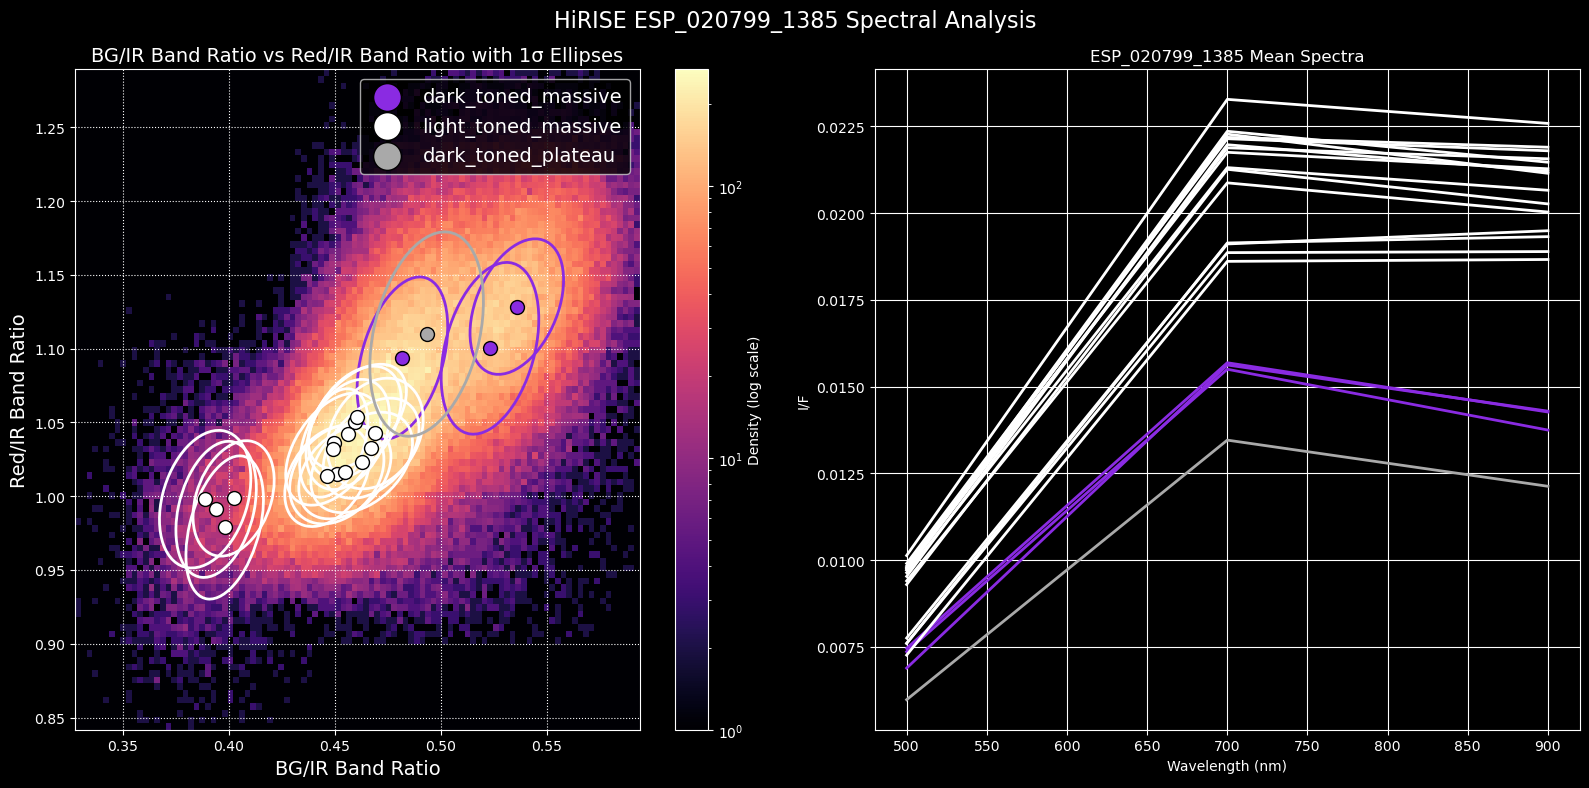

Masking rasters
Masked raster for dark_toned_massive
Masked raster for dark_toned_plateau
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Masked raster for light_toned_massive
Processing 7 ROIs...
  Processing ROI 1/7: dark_toned_massive
Calculating parameters...
    ROI has 704700 pixels, downsampling by factor of 3
  Processing ROI 2/7: dark_toned_plateau
Calculating parameters...
    ROI has 840678 pixels, downsampling by factor of 3


/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_24190/1956969240.py:136: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))


  Processing ROI 3/7: light_toned_massive
Calculating parameters...
  Processing ROI 4/7: light_toned_massive
Calculating parameters...
  Processing ROI 5/7: light_toned_massive
Calculating parameters...
  Processing ROI 6/7: light_toned_massive
Calculating parameters...
  Processing ROI 7/7: light_toned_massive
Calculating parameters...
Plotting density map with statistics...
Creating density plot...
Saved figure to /Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/ESP_020799_1385_Red5_ds_pixel_analysis_invert.png


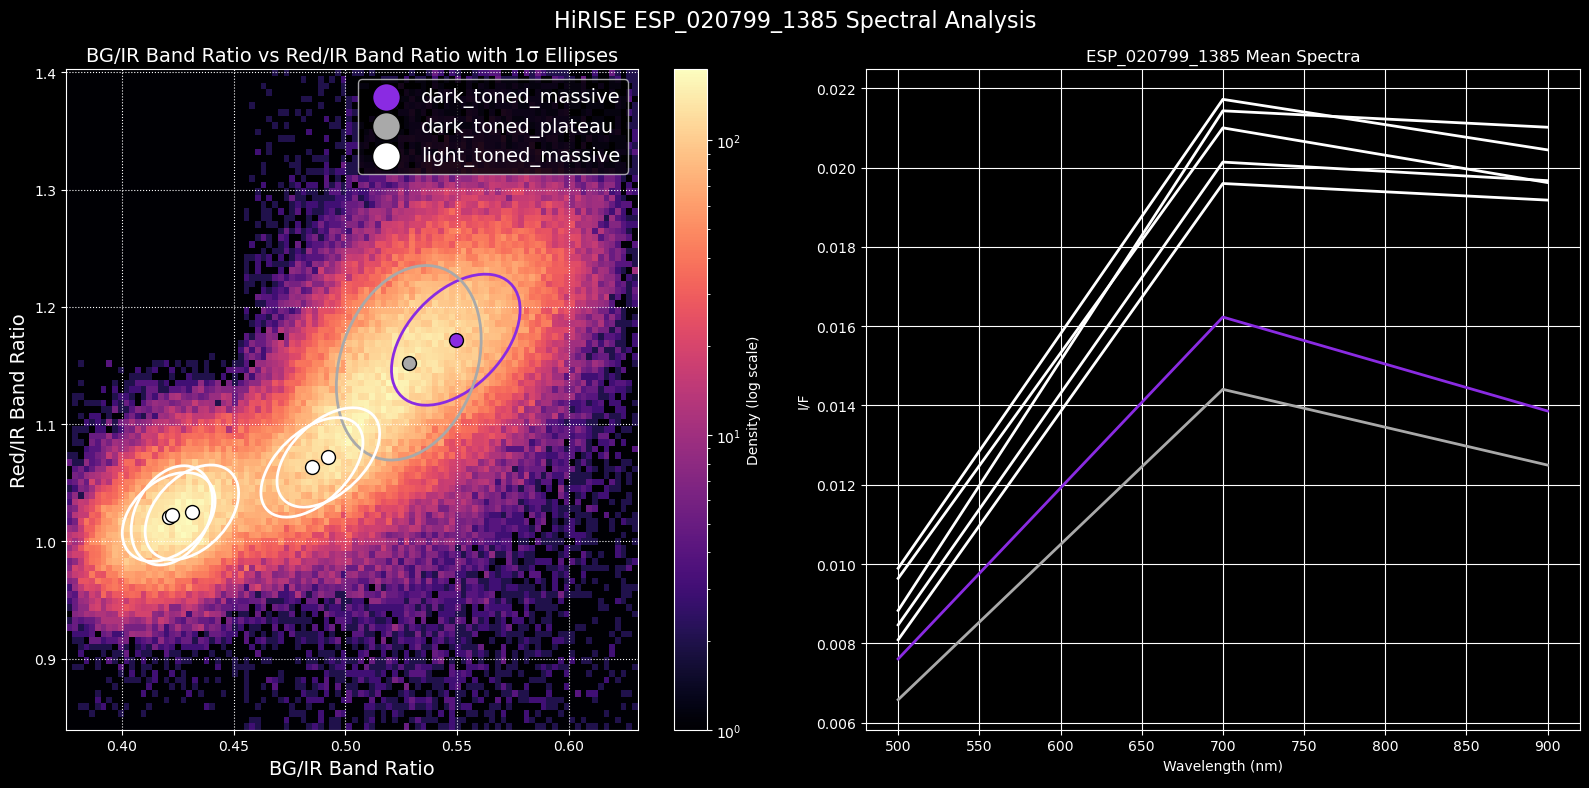

Processing ESP_031269_1395...
Masking rasters
Masked raster for plagioclase
Masked raster for plagioclase
Masked raster for lcp
Masked raster for pink_toned
Masked raster for olivine+hcp
Masked raster for light_toned_rubble
Masked raster for light_toned_rubble
Masked raster for dark_toned_plateau
Masked raster for light_toned_ridge
Masked raster for plagioclase
Masked raster for light_toned_ridge
Masked raster for light_toned_ridge
Masked raster for dark_toned_plateau
Masked raster for dark_toned_plateau
Masked raster for sand
Masked raster for rubble
Processing 16 ROIs...
  Processing ROI 1/16: plagioclase
Calculating parameters...
    ROI has 437763 pixels, downsampling by factor of 3
  Processing ROI 2/16: plagioclase
Calculating parameters...
    ROI has 1221768 pixels, downsampling by factor of 4
  Processing ROI 3/16: lcp
Calculating parameters...
    ROI has 583054 pixels, downsampling by factor of 3
  Processing ROI 4/16: pink_toned
Calculating parameters...
  Processing ROI 5/

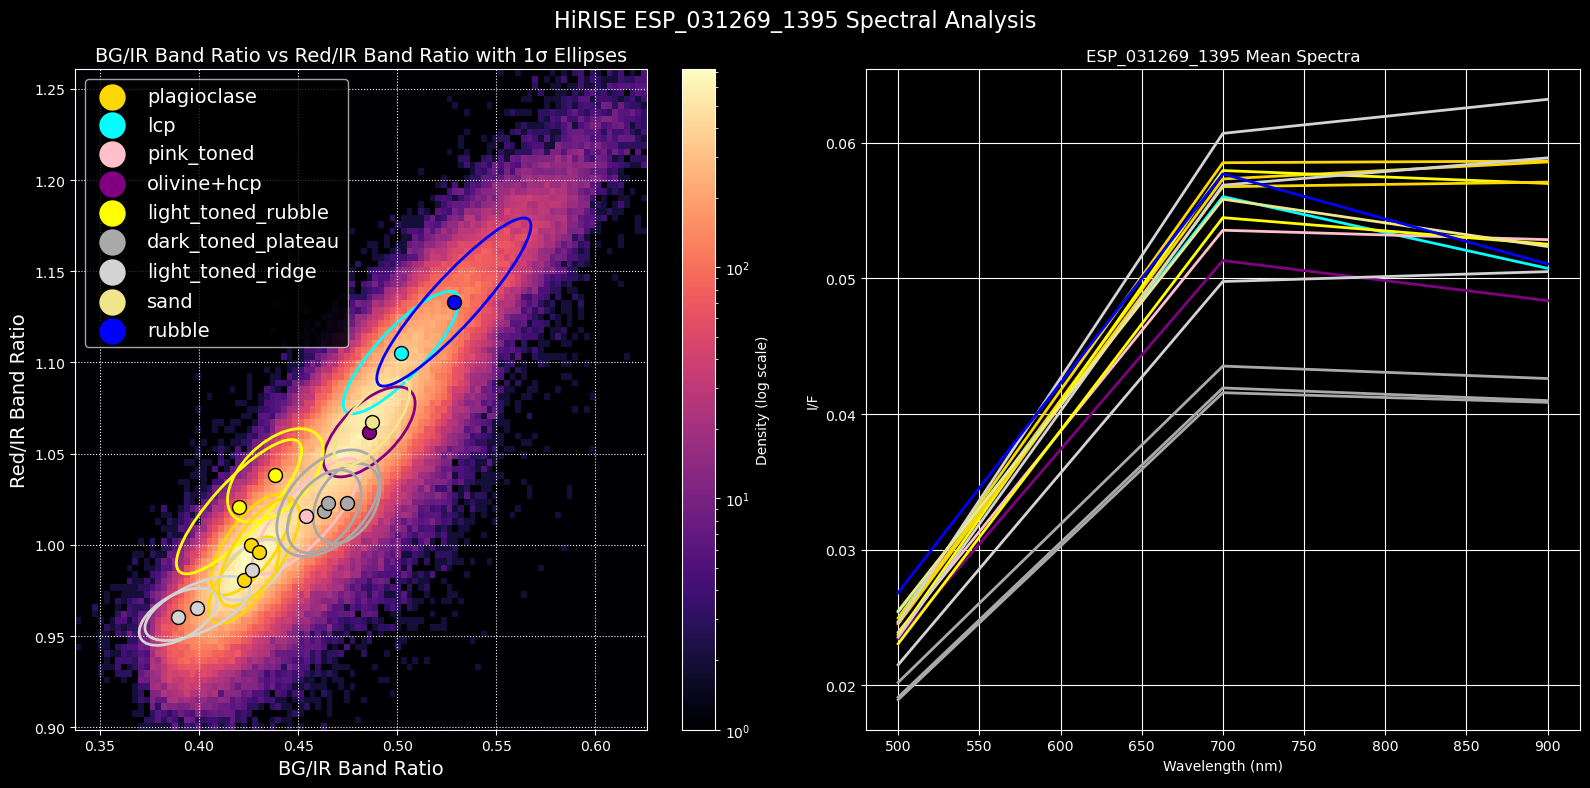

Masking rasters
Masked raster for plagioclase
Masked raster for plagioclase
Masked raster for pink_toned
Masked raster for light_toned_rubble
Masked raster for dark_toned_plateau
Masked raster for blue_terrain
Masked raster for olivine+hcp
Masked raster for lcp
Masked raster for dark_toned_rubble
Processing 9 ROIs...
  Processing ROI 1/9: plagioclase
Calculating parameters...
    ROI has 391193 pixels, downsampling by factor of 2
  Processing ROI 2/9: plagioclase
Calculating parameters...
    ROI has 420595 pixels, downsampling by factor of 3
  Processing ROI 3/9: pink_toned
Calculating parameters...
    ROI has 159424 pixels, downsampling by factor of 2
  Processing ROI 4/9: light_toned_rubble
Calculating parameters...
    ROI has 757332 pixels, downsampling by factor of 3
  Processing ROI 5/9: dark_toned_plateau
Calculating parameters...
    ROI has 1527113 pixels, downsampling by factor of 4
  Processing ROI 6/9: blue_terrain
Calculating parameters...
    ROI has 1064588 pixels, dow

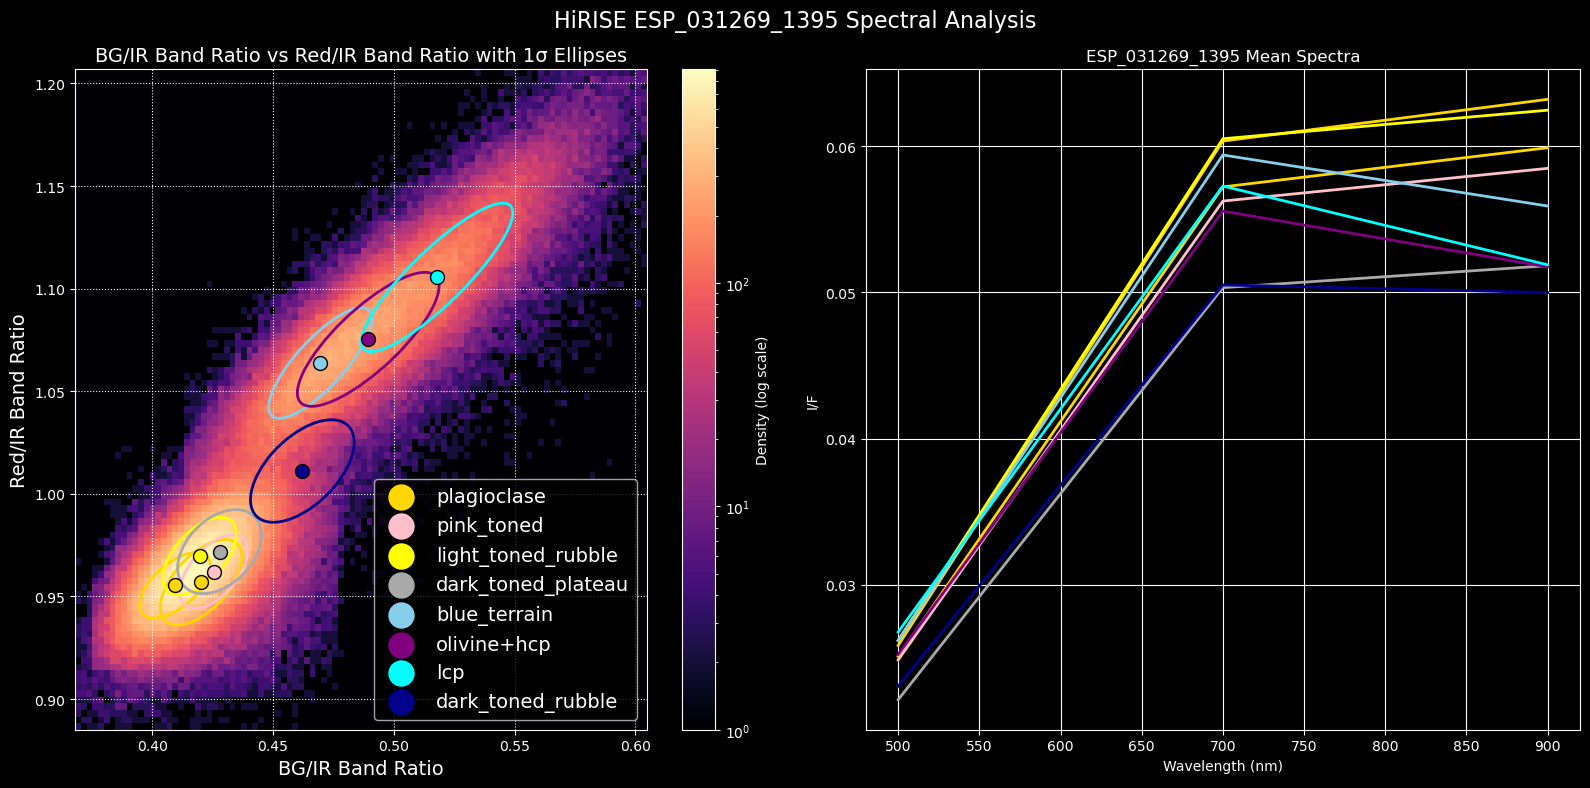

Processing ESP_069064_1390...
Masking rasters
Masked raster for light_toned
Masked raster for light_toned
Masked raster for light_toned_rubble
Masked raster for dark_toned_rubble
Masked raster for lcp
Processing 5 ROIs...
  Processing ROI 1/5: light_toned
Calculating parameters...
  Processing ROI 2/5: light_toned
Calculating parameters...
  Processing ROI 3/5: light_toned_rubble
Calculating parameters...
    ROI has 757521 pixels, downsampling by factor of 3
  Processing ROI 4/5: dark_toned_rubble
Calculating parameters...
    ROI has 203190 pixels, downsampling by factor of 2
  Processing ROI 5/5: lcp
Calculating parameters...
    ROI has 825461 pixels, downsampling by factor of 3
Plotting density map with statistics...
Creating density plot...


/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_24190/1956969240.py:136: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))


Saved figure to /Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/ESP_069064_1390_Red4_ds_pixel_analysis_invert.png


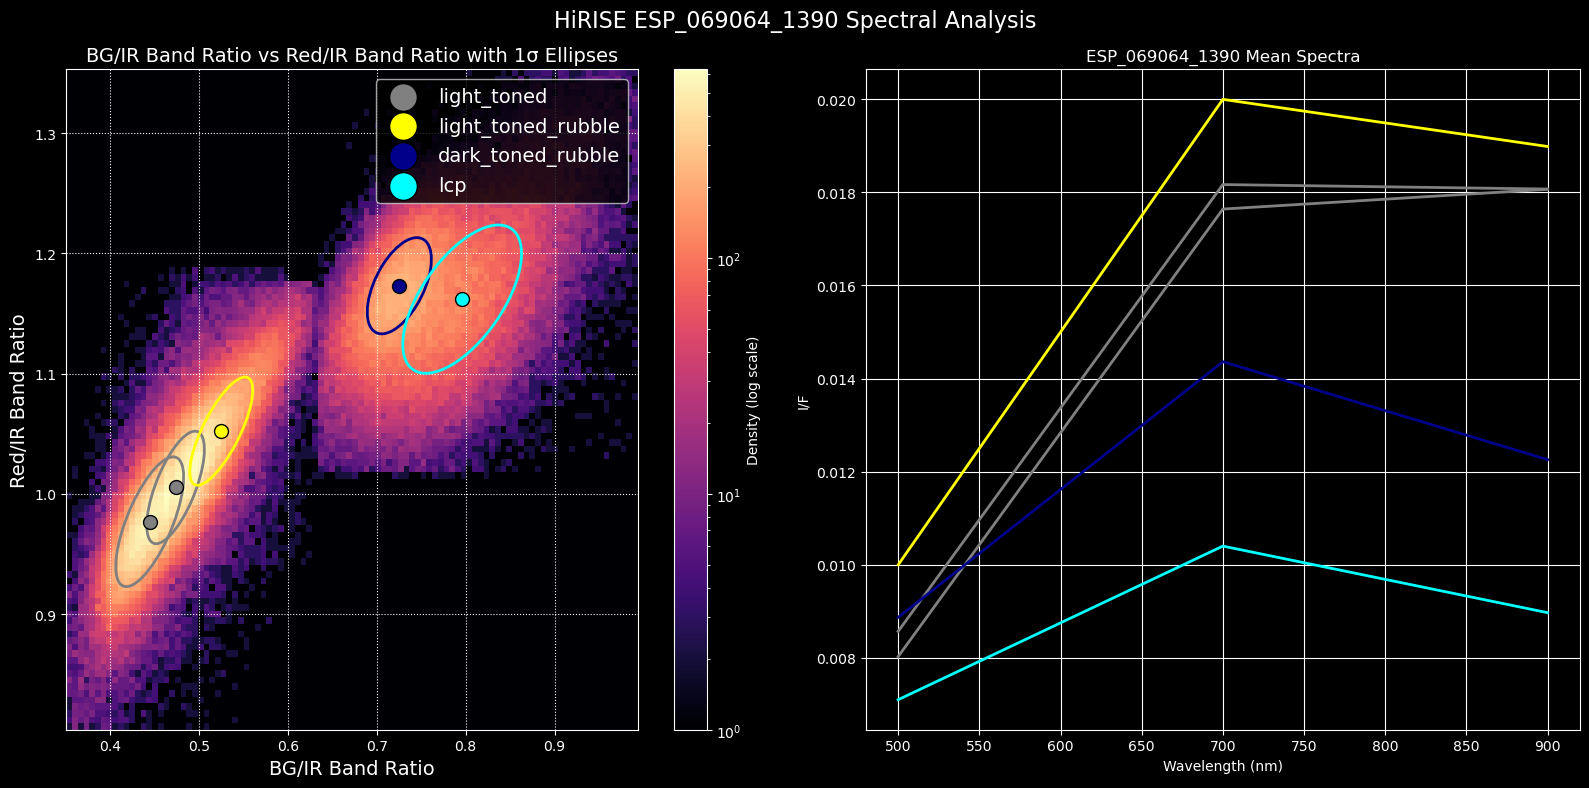

Masking rasters
Masked raster for light_toned
Masked raster for light_toned
Masked raster for light_toned_rubble
Masked raster for light_toned
Masked raster for dark_sand
Masked raster for blue_terrain
Masked raster for dark_sand
Masked raster for orange_sand
Masked raster for dark_sand
Masked raster for blue_sand
Masked raster for orange_sand
Masked raster for orange_sand
Masked raster for blue_sand
Masked raster for blue_sand
Masked raster for orange_sand
Masked raster for blue_sand
Processing 16 ROIs...
  Processing ROI 1/16: light_toned
Calculating parameters...
    ROI has 480411 pixels, downsampling by factor of 3
  Processing ROI 2/16: light_toned
Calculating parameters...
    ROI has 116116 pixels, downsampling by factor of 2
  Processing ROI 3/16: light_toned_rubble
Calculating parameters...
    ROI has 574695 pixels, downsampling by factor of 3
  Processing ROI 4/16: light_toned
Calculating parameters...
  Processing ROI 5/16: dark_sand
Calculating parameters...
    ROI has 1

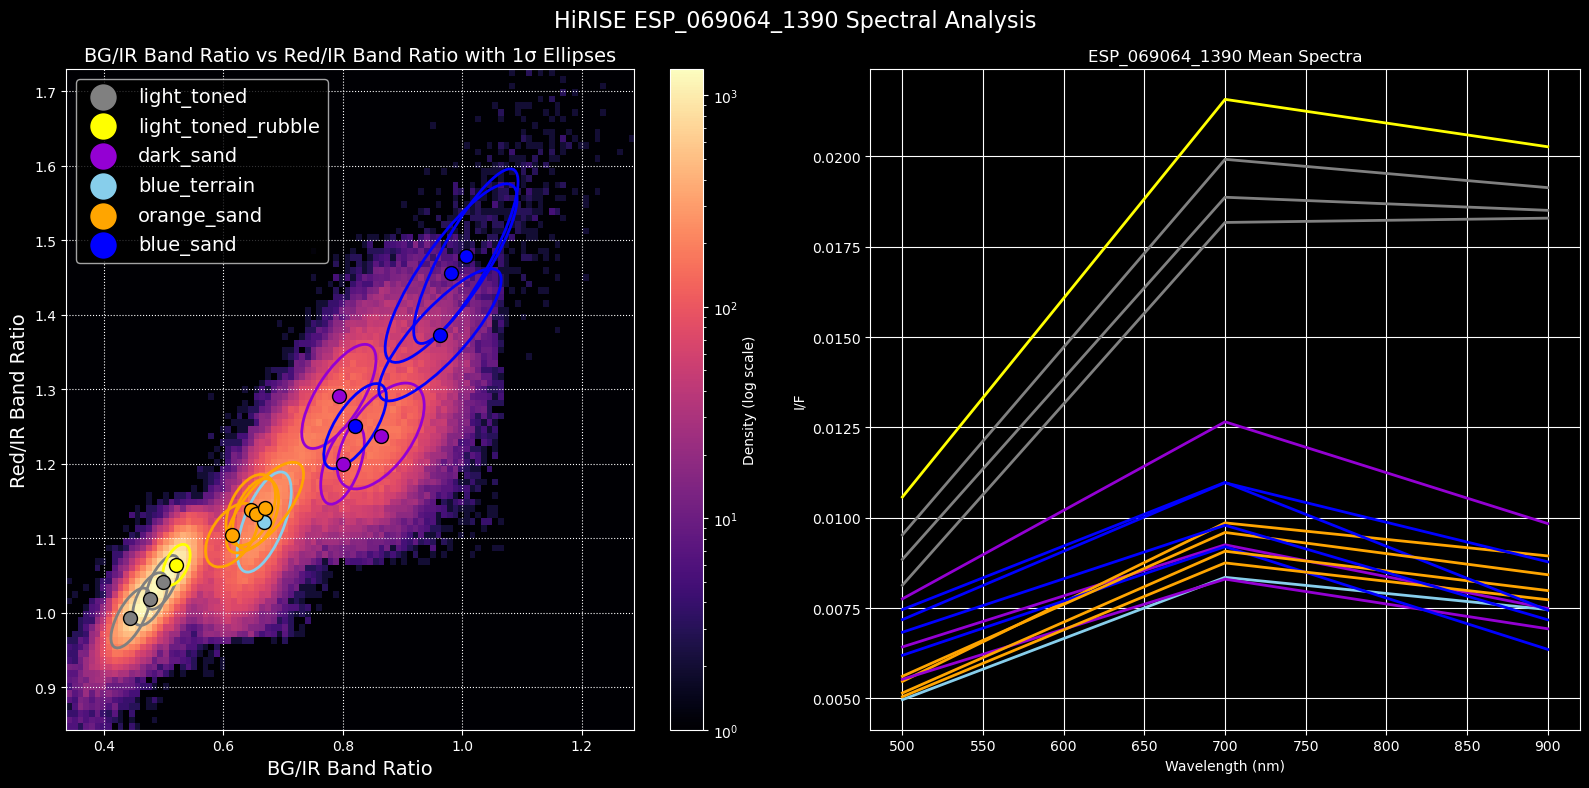

In [11]:
# Inputs
hid_list = ['ESP_020799_1385', 'ESP_031269_1395', 'ESP_069064_1390']
detector_number_list = ['4', '5']

cats_to_include = {'ESP_031269_1395': ['all'], #['plagioclase', 'olivine+hcp', 'lcp', 'olivine+plagioclase', 'pink_toned'], 
                   'ESP_069064_1390': ['all'],
                   'ESP_020799_1385': ['all']
                   }

for hid in hid_list:
    print(f"Processing {hid}...")
    for detector_number in detector_number_list:
        
        gpkg_path = f"../data/hirise_spectral_units/{hid}-RED{detector_number}-DarkSub-Stack_modified.gpkg"
        layer_name = f"{hid}_spectral_units"

        # ---------------------------------
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # YOU NEED TO CHANGE THIS PATH
        # to the location of your HiRISE data. Download the DS data from the articles' Zenodo archive.

        image_path = f"/Volumes/Rohan/Mars_GIS_Data/HiRISE/Argyre/unfiltered_HiRISE/{hid}/{hid}-RED{detector_number}-DarkSub-Stack_modified.tif"
        # --------------------------------

        # Flag to include or exclude 'dark_sub' ROI
        include_dark_sub = False

        # Container for masked rasters
        masked_rasters = []
        min_ids = []
        
        try:
            shapefile = fiona.open(gpkg_path)#, layer=layer_name)
        except ValueError as e:
            print("Available layers in the geopackage:")
            with fiona.open(gpkg_path) as src:
                for layer in src:
                    print(layer)
            print(f"Error opening layer {layer_name}: {e}")
            layer_name = 'hirise_spectral_units'
            shapefile = fiona.open(gpkg_path, layer=layer_name)

        min_ids = [feature['properties']['mineral_id'] for feature in shapefile]

        # Open the source raster
        with rasterio.open(image_path) as src:
            # Ensure both geometries and the image are in the same CRS
            if src.crs != shapefile.crs:
                # Reproject the geometries to the CRS of the raster
                geometries = [feature["geometry"] for feature in shapefile]
                geometries = [shape(geom).buffer(0) for geom in geometries]
                geometries = [rasterio.warp.transform_geom(shapefile.crs, src.crs, geom) for geom in geometries]
            else:
                geometries = [shape(feature["geometry"]).buffer(0) for feature in shapefile]

            # Filter geometries based on cats_to_include
            if cats_to_include[hid] != ['all']:
                filtered_geometries = []
                filtered_min_ids = []
                for geom, min_id in zip(geometries, min_ids):
                    if min_id in cats_to_include[hid]:
                        filtered_geometries.append(geom)
                        filtered_min_ids.append(min_id)
                geometries = filtered_geometries
                min_ids = filtered_min_ids
            # Loop over each geometry (ROI) to create a separate masked raster
            print('Masking rasters')
            ids_to_remove = []
            for i, geom in enumerate(geometries):
                # Mask the raster using the current ROI geometry
                try:
                    out_image, out_transform = mask(src, [geom], crop=True)
                    # Store the masked image
                    # Threshold very low values (< 3) to NaN
                    # out_image = np.where(out_image < 1, np.nan, out_image)
                    out_image = np.where(out_image == 65535, np.nan, out_image)
                    masked_rasters.append(out_image)
                    print(f"Masked raster for {min_ids[i]}")
                except:
                    print(f"Error masking raster for {min_ids[i]}")
                    ids_to_remove.append(i)
                    continue

        
        geometries = [geom for i, geom in enumerate(geometries) if i not in ids_to_remove]
        min_ids = [min_id for i, min_id in enumerate(min_ids) if i not in ids_to_remove]

        # Calculate parameters for every pixel in each ROI
        numerator = 'BG'
        denominator = 'IR'
        numerator2 = 'Red'
        denominator2 = 'IR'
        
        all_roi_band_ratios = []
        all_roi_band_ratios2 = []
        all_roi_angles = []
        all_roi_areas = []
        mean_spectra = []
        
        # Add some progress reporting
        print(f"Processing {len(masked_rasters)} ROIs...")
        
        # Set a maximum number of pixels to process per ROI to improve performance
        MAX_PIXELS = 100000  # Adjust this number based on your needs
        
        for i, masked_raster in enumerate(masked_rasters):
            print(f"  Processing ROI {i+1}/{len(masked_rasters)}: {min_ids[i]}")
            
            mean_spectrum = np.nanmean(masked_raster, axis=(1, 2))
            
            mean_spectra.append(mean_spectrum)
            
            # Check size of the ROI
            total_pixels = masked_raster.shape[1] * masked_raster.shape[2]
            
            # If ROI is very large, downsample to improve performance
            print('Calculating parameters...')
            if total_pixels > MAX_PIXELS:
                # Calculate downsampling factor
                ds_factor = int(np.ceil(np.sqrt(total_pixels / MAX_PIXELS)))
                print(f"    ROI has {total_pixels} pixels, downsampling by factor of {ds_factor}")
                
                # Downsample by taking every nth pixel
                downsampled_raster = masked_raster[:, ::ds_factor, ::ds_factor]
                
                # Calculate parameters on the downsampled data
                ratio_image, angle_image, area = calculate_parameters_for_pixels(
                    downsampled_raster, numerator, denominator)
                ratio_image2, _, _ = calculate_parameters_for_pixels(
                    downsampled_raster, numerator2, denominator2)
            else:
                # Calculate parameters for each pixel in the original data
                ratio_image, angle_image, area = calculate_parameters_for_pixels(
                    masked_raster, numerator, denominator)
                ratio_image2, _, _ = calculate_parameters_for_pixels(
                    masked_raster, numerator2, denominator2)
            
            # Store the parameter images
            all_roi_band_ratios.append(ratio_image)
            all_roi_band_ratios2.append(ratio_image2)
            all_roi_angles.append(angle_image)
            all_roi_areas.append(area)

        # Prepare colors for plots
        colors = [mineral_colors.get(min_id, 'gray') for min_id in min_ids]
        
        # Create subplots
        # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot density map with statistics on the first subplot
        print("Plotting density map with statistics...")
        plot_density_with_statistics(ax1, all_roi_band_ratios, all_roi_band_ratios2, 
                                    min_ids, colors, numerator, denominator, 'band_ratio', 'band_ratio2', numerator2, denominator2)
        # plot_density_with_statistics(ax1, all_roi_band_ratios, all_roi_angles, 
        #                             min_ids, colors, numerator, denominator, 'band_ratio', 'angle')
        # plot_density_with_statistics(ax3, all_roi_band_ratios, all_roi_areas, 
        #                             min_ids, colors, numerator, denominator, 'band_ratio', 'area')
        # plot_density_with_statistics(ax4, all_roi_band_ratios, all_roi_band_ratios2, 
        #                             min_ids, colors, numerator, denominator, 'band_ratio', 'band_ratio2', numerator2, denominator2)

        # Wavelengths for the respective bands (in nm)
        wIR = 900  # Near-Infrared
        wRed = 700  # Red
        wBG = 500  # Blue/Green
        wvl = [wIR, wRed, wBG]
        
        # Plot the spectra on the second subplot
        for i, spec in enumerate(mean_spectra):
            ax2.plot(wvl, spec[:3][::-1], alpha=1, label=min_ids[i], c=colors[i], linewidth=2)
        
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('I/F')
        ax2.set_title(f'{hid} Mean Spectra')
        ax2.grid(True)
        
        plt.suptitle(f'HiRISE {hid} Spectral Analysis', fontsize=16)
        plt.tight_layout()
        
        # Save the figure (optional)
        # output_path = f"../data/{hid}_Red{detector_number}_ds_pixel_analysis.png"
        output_path = f"/Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/{hid}_Red{detector_number}_ds_pixel_analysis_invert.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
        
        plt.show()

        # Close the shapefile
        shapefile.close()